<a href="https://colab.research.google.com/github/Neulvo/py_yum/blob/master/seq2seq_bi_lstm_tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Concatenate

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

In [ ]:
from matplotlib import rc
from matplotlib import font_manager as fm
from matplotlib import rcParams
import matplotlib as mpl
#nanum 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")
nanum_font
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
current_font()
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
#여기가 폰트 사이즈를 정하는 곳.
font_name = fm.FontProperties(fname=path, size=16).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

sys_font number: 48
nanum_font number: 31
Python 3.6.9
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0
NanumBarunGothic


In [ ]:
path_to_file='/content/drive/My Drive/NLP/data/kor.xlsx'

In [ ]:
kor_eng= pd.read_excel(path_to_file, sheet_name='Sheet1') 

In [ ]:
kor_eng

,mid_sid,ko,en
0,1,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.
1,2,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here."
2,3,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.
3,4,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.
4,5,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.
...,...,...,...
74995,74996,나의 고민은 학교가 멀어서 통학하기 힘들어.,My worry is commuting to school because it's t...
74996,74997,난 지금 내고양이때문에 충분히 힘들어.,I am going under enough difficulties because o...
74997,74998,나와 대화가 어려운 것이 많이 힘들어?,Is having difficulties in talking with me too ...
74998,74999,하루에 한번 연락하는게 그렇게 힘들어?,Is it that difficult to call once a day?


In [ ]:
#  # Download the file
# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [ ]:
 # Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  # w = unicode_to_ascii(w.lower().strip())
  w=w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z가-힣?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# en_sentence = u"May I borrow this book?"
# sp_sentence = u"¿Puedo tomar prestado este libro?"
# print(preprocess_sentence(en_sentence))
# print(preprocess_sentence(sp_sentence).encode('utf-8'))
 

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(lines, num_examples):
  # lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)
 

In [ ]:
kor_eng_corp=(kor_eng['ko']+'\t'+kor_eng['en']).tolist()

In [ ]:
kor_eng_corp

In [ ]:
ko, en = create_dataset(kor_eng_corp, None)
print(ko[-1])
print(en[-1])


<start> 어린 아이들이 스포츠를 즐기기엔 많이 힘들죠 . <end>
<start> it is difficult for young children to enjoy sports . <end>


In [ ]:
# en, sp = create_dataset(path_to_file, None)
# print(en[-1])
# print(sp[-1])
 

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
 def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [ ]:
# Try experimenting with the size of that dataset
num_examples = 75000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(kor_eng_corp, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
 

In [ ]:
 # Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


60000 60000 15000 15000


In [ ]:
def convert(lang, tensor):
 for t in tensor:
   if t!=0:
     print ("%d ----> %s" % (t, lang.index_word[t]))
 

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])
 

Input Language; index to word mapping
1 ----> <start>
1272 ----> 저기
25685 ----> 사막
3088 ----> 가운데
2249 ----> 그녀
76358 ----> 혼자서요
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
87 ----> out
33 ----> there
12 ----> in
5 ----> the
2879 ----> desert
70 ----> all
58 ----> by
2933 ----> herself
3 ----> .
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 1000
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
 

(TensorShape([64, 21]), TensorShape([64, 21]))

In [ ]:
 class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.Bidirectional(LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state = hidden)
    # state_h = Concatenate()([state_fh, state_bh])
    # state_c = Concatenate()([state_fc, state_bc])
    return output, state_fh, state_fc, state_bh, state_bc

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden_fh, sample_hidden_fc, sample_hidden_bh, sample_hidden_bc = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state FH shape: (batch size, units) {}'.format(sample_hidden_fh.shape))
print ('Encoder Hidden state FC shape: (batch size, units) {}'.format(sample_hidden_fc.shape))
print ('Encoder Hidden state BH shape: (batch size, units) {}'.format(sample_hidden_bh.shape))
print ('Encoder Hidden state BC shape: (batch size, units) {}'.format(sample_hidden_bc.shape))

Encoder output shape: (batch size, sequence length, units) (64, 21, 2048)
Encoder Hidden state FH shape: (batch size, units) (64, 1024)
Encoder Hidden state FC shape: (batch size, units) (64, 1024)
Encoder Hidden state BH shape: (batch size, units) (64, 1024)
Encoder Hidden state BC shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
 def __init__(self, units):
   super(BahdanauAttention, self).__init__()
   self.W1 = tf.keras.layers.Dense(units)
   self.W2 = tf.keras.layers.Dense(units)
   self.V = tf.keras.layers.Dense(1)

 def call(self, query1, query2, values):
   # query hidden state shape == (batch_size, hidden size)
   # query_with_time_axis shape == (batch_size, 1, hidden size)
   # values shape == (batch_size, max_len, hidden size)
   # we are doing this to broadcast addition along the time axis to calculate the score
   query=Concatenate()([query1, query2])
   query_with_time_axis = tf.expand_dims(query, 1)

   # score shape == (batch_size, max_length, 1)
   # we get 1 at the last axis because we are applying score to self.V
   # the shape of the tensor before applying self.V is (batch_size, max_length, units)
   score = self.V(tf.nn.tanh(
       self.W1(query_with_time_axis) + self.W2(values)))

   # attention_weights shape == (batch_size, max_length, 1)
   attention_weights = tf.nn.softmax(score, axis=1)

   # context_vector shape after sum == (batch_size, hidden_size)
   context_vector = attention_weights * values
   context_vector = tf.reduce_sum(context_vector, axis=1)

   return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden_fh, sample_hidden_bh, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
 

Attention result shape: (batch size, units) (64, 2048)
Attention weights shape: (batch_size, sequence_length, 1) (64, 21, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.Bidirectional(LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden_fh, hidden_fc, hidden_bh, hidden_bc, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden_fh, hidden_bh, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state_fh, state_fc, state_bh, state_bc = self.lstm(x, initial_state=[hidden_fh, hidden_fc, hidden_bh, hidden_bc])
    # state_h = Concatenate()([state_fh, state_bh])
    # state_c = Concatenate()([state_fc, state_bc])

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state_fh, state_fc, state_bh, state_bc, attention_weights
 

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden_fh,sample_hidden_fc, sample_hidden_bh, sample_hidden_bc, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
 

Decoder output shape: (batch_size, vocab size) (64, 19231)


In [ ]:
optimizer = tf.keras.optimizers.SGD()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
 

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
 

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden_fh, enc_hidden_fc, enc_hidden_bh, enc_hidden_bc = encoder(inp, enc_hidden)

    dec_hidden_fh = enc_hidden_fh
    dec_hidden_fc = enc_hidden_fc    
    dec_hidden_bh = enc_hidden_bh
    dec_hidden_bc = enc_hidden_bc

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden_fh,dec_hidden_fc, hidden_bh, hidden_bc, _ = decoder(dec_input, dec_hidden_fh,dec_hidden_fc, dec_hidden_bh, dec_hidden_bc, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.2624
Epoch 1 Batch 100 Loss 3.5499
Epoch 1 Batch 200 Loss 3.3194
Epoch 1 Batch 300 Loss 3.1638
Epoch 1 Batch 400 Loss 3.2956
Epoch 1 Batch 500 Loss 3.1399
Epoch 1 Batch 600 Loss 3.2473
Epoch 1 Batch 700 Loss 3.0858
Epoch 1 Batch 800 Loss 3.1496
Epoch 1 Batch 900 Loss 3.1368
Epoch 1 Loss 3.3569
Time taken for 1 epoch 346.6418650150299 sec

Epoch 2 Batch 0 Loss 3.0023
Epoch 2 Batch 100 Loss 2.9955
Epoch 2 Batch 200 Loss 3.0002
Epoch 2 Batch 300 Loss 2.9611
Epoch 2 Batch 400 Loss 3.1157
Epoch 2 Batch 500 Loss 2.9861
Epoch 2 Batch 600 Loss 3.0196
Epoch 2 Batch 700 Loss 2.9472
Epoch 2 Batch 800 Loss 2.8854
Epoch 2 Batch 900 Loss 3.0388
Epoch 2 Loss 2.9856
Time taken for 1 epoch 311.03324937820435 sec

Epoch 3 Batch 0 Loss 2.8603
Epoch 3 Batch 100 Loss 2.8929
Epoch 3 Batch 200 Loss 3.0075
Epoch 3 Batch 300 Loss 2.9033
Epoch 3 Batch 400 Loss 2.9381
Epoch 3 Batch 500 Loss 2.9695
Epoch 3 Batch 600 Loss 3.0018
Epoch 3 Batch 700 Loss 2.9914
Epoch 3 Batch 800 Loss 2.8959
Epo

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units)) for i in range(4)]
  enc_output, enc_hidden_fh, enc_hidden_fc, enc_hidden_bh, enc_hidden_bc = encoder(inputs, hidden)

  dec_hidden_fh = enc_hidden_fh
  dec_hidden_fc = enc_hidden_fc
  dec_hidden_bh = enc_hidden_bh
  dec_hidden_bc = enc_hidden_bc

  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden_fh, dec_hidden_fc, dec_hidden_bh, dec_hidden_bc, attention_weights = decoder(dec_input,
                                                                                                         dec_hidden_fh,
                                                                                                         dec_hidden_fc,
                                                                                                         dec_hidden_bh,
                                                                                                         dec_hidden_bc,
                                                                                                         enc_output)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
 

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
 

In [ ]:
ko[:5]

('<start> 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end>',
 '<start> 선생님 이문장이 이해가 안 가요 . <end>',
 '<start> 컴퓨터를 시작하면 시간이 너무 빠르게 가요 . <end>',
 '<start> 나는 오늘 자정에 한국으로 돌아 가요 . <end>',
 '<start> 나는 일어나자마자 화장실에 가요 . <end>')

Input: <start> 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end>
Predicted translation: i want to a lot with a friend <end> 


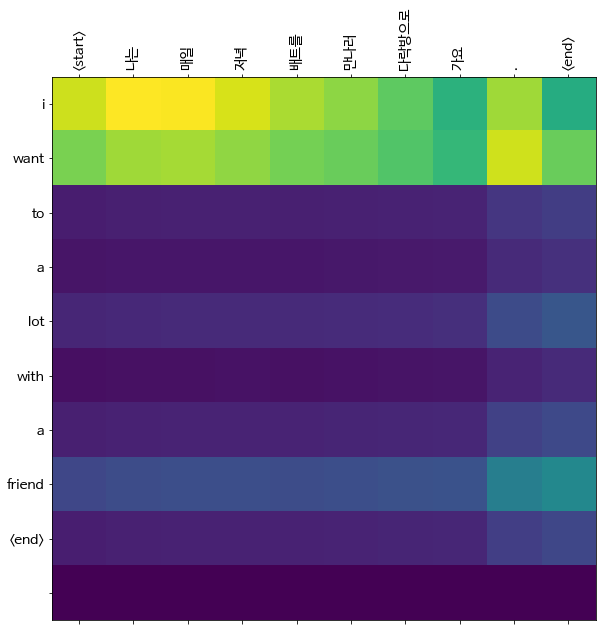

Input: <start> 선생님 이문장이 이해가 안 가요 . <end>
Predicted translation: i want to a lot with a friend <end> 


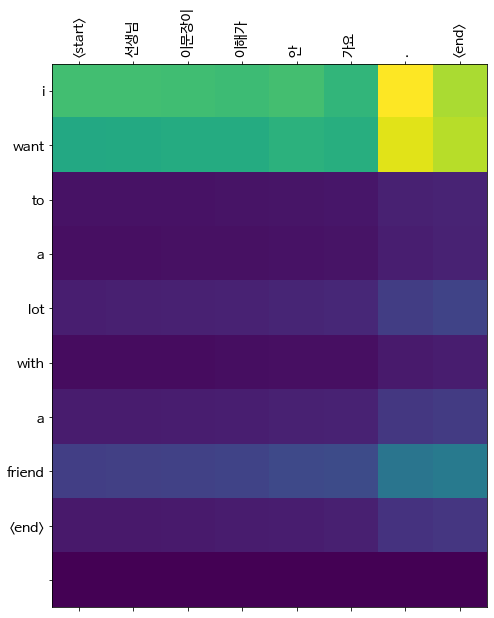

Input: <start> 컴퓨터를 시작하면 시간이 너무 빠르게 가요 . <end>
Predicted translation: i want to a lot with a friend <end> 


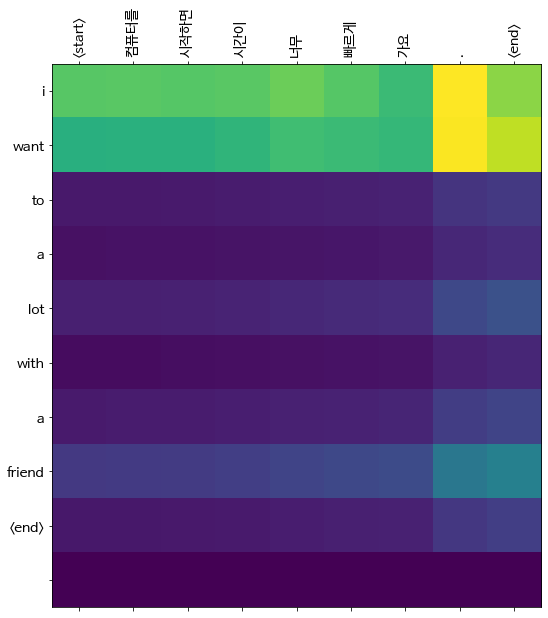

Input: <start> 나는 오늘 자정에 한국으로 돌아 가요 . <end>
Predicted translation: i want to a lot with a friend <end> 


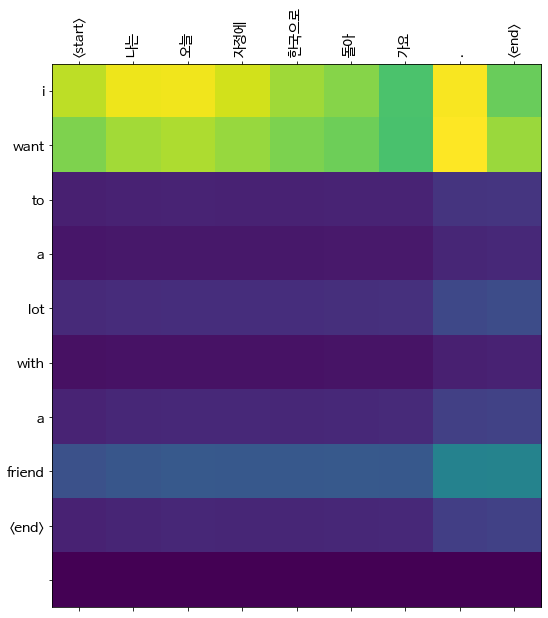

Input: <start> 나는 일어나자마자 화장실에 가요 . <end>
Predicted translation: i am a lot with a friend <end> 


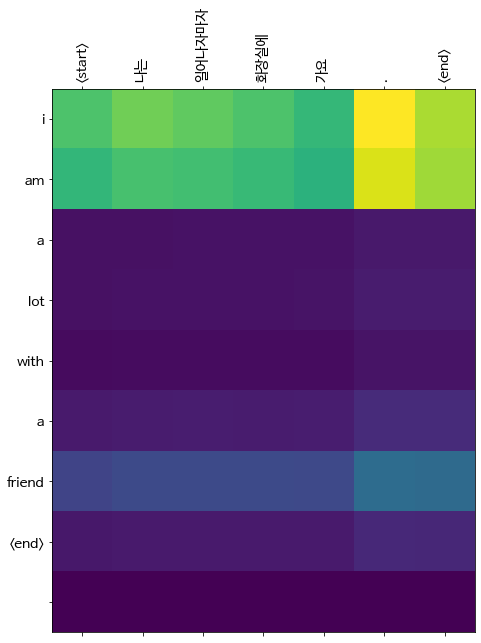

Input: <start> 지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요 . <end>
Predicted translation: i want to a lot with a friend <end> 


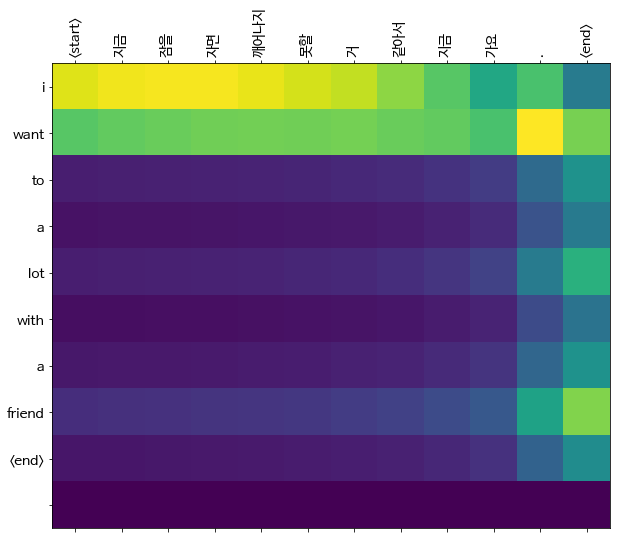

Input: <start> 학교가 끝나자마자 기숙사로 가요 . <end>
Predicted translation: i will go to the lot <end> 


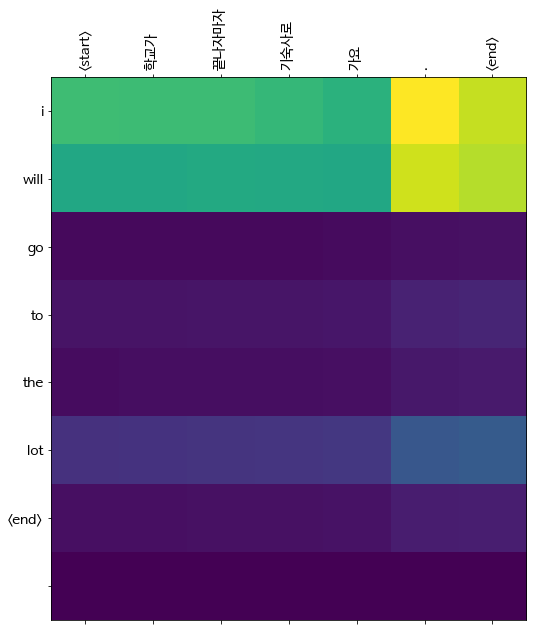

Input: <start> 대한민국 남자라면 모두 대에 의무적으로 군대에 가요 . <end>
Predicted translation: i will go to the lot with a friend <end> 


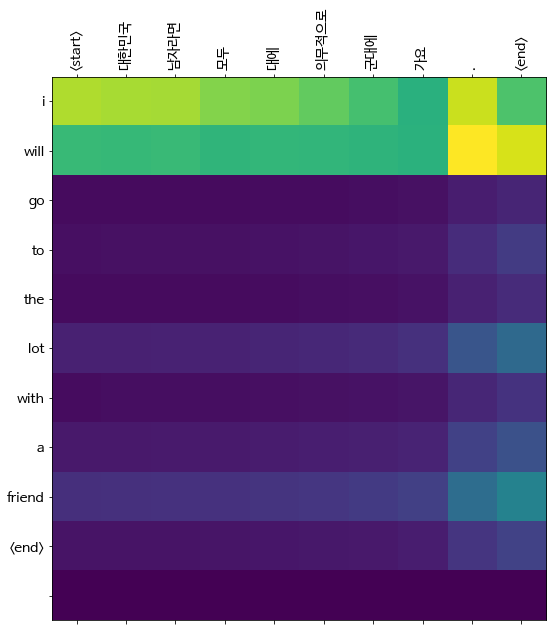

Input: <start> 오늘밤에 비자 때문에 한국에 가요 . <end>
Predicted translation: i am a lot with a friend <end> 


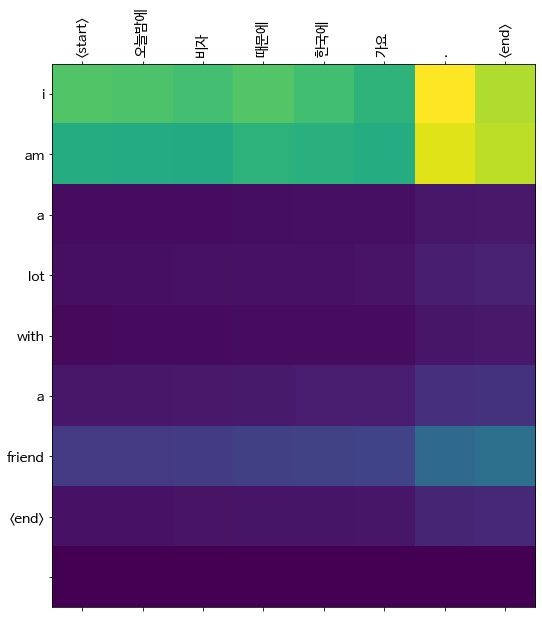

Input: <start> 오늘은 새 자동차를 받으러 가요 . <end>
Predicted translation: i am a lot with a friend <end> 


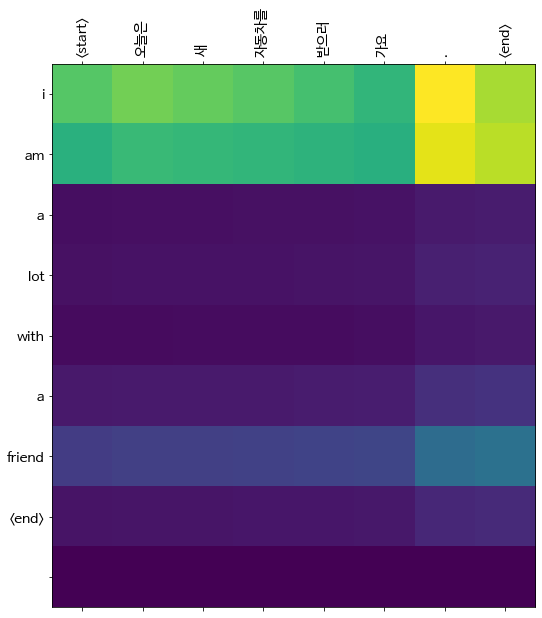

In [ ]:
for ko in ko[:10]:
  ko=re.sub('<[^>]*>','',ko)
  translate(ko)